<a href="https://colab.research.google.com/github/bigyunicorn/fastai22/blob/main/lesson04/Getting_started_with_NLP_for_absolute_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This is very specific to Google Colab to use HuggingFace(HF) tokenizer.
# We absolutely need to use tokenizer for this notebook.
# For the smooth experiment, I decided to put this code at the top so you can simply install it and restart the kernel as we need to do so.
# Check this github ticket for more details: https://github.com/huggingface/transformers/issues/9750

# Please restart your kernal after installing sentencepiece package.
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Background
I reorganized Jeremy's Notebook for [FastAI lesson04](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners#Training) so that my future self can easily recall the content and leverage it in the future.

I am mainly focusing on the high level key points from the notes. All the code is directly coming from the Jeremy's notebook.

___
#### Notes:
I wanted to use the coding aspect leveraing an AI coding tool such as copilot or codey. Unfortunately, I do not have the access to the GPU supported GitHub Codespce or the access to Codey in Google Colab as of now (06/21/23).

I am planning to try it once either of the feature is available to me. I've tried creating [my notebook](https://github.com/bigyunicorn/fastai22/blob/main/lesson03/neural-network-from-scratch.ipynb) from the scratch by using github copilot for FastAI lesson 03. It was very helpful as I could focus on the essense of each notebook that Jeremy goes over in the lecture without worrying about the syntax too much.

I highly recommend trying this method out to others if you have access.
___
#### Tips for taking the FastAI course.
- Watch a lecture e2e one time.
- Copy each given notebook and follow through on your own.
- Think about main steps from the notebook and write those down (I usually use these main steps as the title of each section).
- Expand each of the main steps and break it down smaller steps so you can easily ask the copilot to write the code.
- Reproduce the results.
- Publish your notebook to github.


# A few key points from the lesson 04


*   This notebook focuses on the e2e process of downloading an NLP dataset,
* pre-processing the data to feed it to a model,
* how to use HuggingFace transformer APIs to access to a pre-trained model, and
* fine-tune our model with our data to solve the given problem.


# Important Context
* The given problem we are going to use:
  - We are tasked with comparing two words or short phrases, and scoring them based on whether they're similar or not, based on which patent class they were used in. ([U.S. Patent Phrase to Phrase Matching](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/data))
     - Check the `data` tab in the kaggle dataset/competition to understand how the data looks like. But basically,
     - Two words/short phrases are: `anchor` and `target`.
     - Similarity: `score` column.
     - Patent class: `context`.
  - We are basically creating a predictive model that accepts texts as input and return a certain category (ex: 1, 0.75, 0.5, 0.25).
* Interesting thing to know:  
  - Language model is a model that predicts a word that will come next. But with our creativity, we can turn this model to solve a classification problem.
  - To do so, we modify the given input in a way that can turn the problem to a classification problem.
  - The method we are using is: we create a new column that contains the text that combines the values of columns we are interested in as the data seem to provide useful information to our model.


# A. Get the dataset and get familiar with the dataset.
In this section, I am going to do the following steps to get the data that I need.
- (1) Get the dataset from Kaggle
    - Install the kaggle python package to use kaggle API to fetch the data.
    - unzip the dataset
- (2) Check the dataset structure & explore the data.
  - If the file type is csv, use the pandas library to
    - read the csv file.
    - check the dataset description.
        - understand the data features based on the description.
- (3) Convert the input (each row) so that we can solve the problem as a NLP classifier.
    - create a new column (input) that combines columns that need.
    - Get the first few columns of the column.

## Set up:
- Make sure your kernel is running on GPU.
- Get Kaggle API key from Kaggle (it will download kaggle.json).
- Copy the key value and put it in the right below cell.
- More details: https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners#Introduction

In [2]:
creds = '{"username":"<your kaggle user name>","key":"<your kaggle api key>"}'

In [3]:
# Remove this code when I am pushing it.
creds = '{"username":"bigyunicorn","key":"82491e77e52a6a2821291545601d7f27"}'

In [4]:
# only need to run once.
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

Okay, now ready to use Kaggle API to download the dataset!

Let's first install the kaggle package.

## Step 1: Get the dataset from Kaggle

In [5]:
# install the kaggle package so we can use its API.
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# The below is useful code to fetch dataset we are interested in from Kaggle.
# you can use the same code if you are on kaggle.
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/titanic')
else:
    path = Path('us-patent-phrase-to-phrase-matching') #kaggle dataset data tab has this name at the end.
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path)) # this is the kagglge python library API
        zipfile.ZipFile(f'{path}.zip').extractall(path) # extract all files from zip

Note: the below is a bsh command to download the data. Github copilot might recommend this line.

`!kaggle competitions download -c us-patent-phrase-to-phrase-matching`

What i just did above is loading the kaggle dataset to google colab. The reason I chose this is a) I prefer google colab over kaggle and b) I think i have flexibility to get more GPU if i need to.

## Step 2: Check the dataset structure and explore the data.

In [7]:
# Now, let's see the file structure of Kaggle downloaded dataset
!ls {path}

sample_submission.csv  test.csv  train.csv


Once I confirmed that the files are in csv, I am going to use pandas, as it is for handling csv files. Google Colab already installed pandas so I can skip `pip install pandas` and directly import the library as pd.

In [9]:
import pandas as pd # Colab has it installed already.

Then we are going to read the csv file into this notebook.

In [10]:
df = pd.read_csv(path/'train.csv')

In [11]:
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


By default describe method only includes numerical value. By having object, I can include string.

In [12]:
df.describe(include='object')

,id,anchor,target,context
count,36473,36473,36473,36473
unique,36473,733,29340,106
top,37d61fd2272659b1,component composite coating,composition,H01
freq,1,152,24,2186


We will learn more about how to explore data in my separate notebook that will cover Jeremy's notebook, [Iterate like a grandmaster!](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/comments). At this point, just get an idea over columns that we care.

## Step 3: Convert the input (each row) so that we can solve the problem as a NLP classifier.

As an effort to convert the problem into NLP classification problem, we are going to concatenate each column value and create a new string per each row. This new string will be saved as a separate column called 'input'.

The separator (ex: TEXT1, TEXT2, etc) was randomly chosen :). Spoiler: we will exlore different separators in another notebook.

In [13]:
df['input'] = "TEXT1: " + df.context +"; TEXT2: " + df.target+ "; ANC1: " + df.anchor

In [14]:
# Let's see a few first rows of this column.
df.input.head() # dotted notation is one way to access a column in dataframe.

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [15]:
df['input'].head() # Btw, We can also access it like a dictionary

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

# B. Fine-tune an NLP Model with our data.

In this section, I am going to do the following steps to fine-tune an NLP model with our data.
- (1) Choose an NLP model that I want to use.
- (2) Get a tokenizer object for the model by using the hugging face transformer’s autoknezier.
- (3) Prepare the inputs and the labels.
- (4) Prepare the training set and validation set.
- (5) Decide what metrics to use.
- (6) Train the model with our pre-processed data.
- (7) Prepare the test set and do inference using the test data set.
- (8) Expansion: What we can do to improve the metrics?  

## Set up

In this chapter, the way we are going to use is using [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) library. This library provides a simple API to apply a wide range of state-of-the art pretrained NLP [models](https://huggingface.co/models) to perform tasks (ex: text classification, summarization, translation and more).

As such, we need to understand how this Transformers library API works.

First and foremost, it accepts the data in the type called Dataset.


A lot of utilites to work on Dataset are available via [Datasets Huggingface library](https://huggingface.co/docs/datasets/index).

Datasets library does provide a way to load the csv data simliar to Pands. According to ChatGPT, pandas is a good chocie for a small and simple CSV files (simple in a sense that the data that the file contains are straightforward data type unlike JSONs). As for our data, we confirmed that it is pretty small and the data itself is pretty primitive datatype, we decide to load csv files via pandas.

This means we need to convert Dataframe object to Dataset.


In [16]:
 #installing huggingface dataset libraries; https://huggingface.co/docs/datasets/index
!pip install -q datasets

In [17]:
# Convert panda's dataframe to HuggingFace Datset type.
from datasets import Dataset
ds = Dataset.from_pandas(df)

In [18]:
# Let's see how Dataset object looks like.
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [19]:
# Let's see how the `input` column looks like in this Dataset ds
# because each row in this column is the input we are going to give it to our model.
# printing out only five rows as the whole set is pretty large.
ds['input'][0:5]

['TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 'TEXT1: A47; TEXT2: act of abating; ANC1: abatement',
 'TEXT1: A47; TEXT2: active catalyst; ANC1: abatement',
 'TEXT1: A47; TEXT2: eliminating process; ANC1: abatement',
 'TEXT1: A47; TEXT2: forest region; ANC1: abatement']

## Step 1: Choose an NLP model that I want to use.
As you can see, each input is in a text. The deep learning model expects its inputs to be in numerical value. As such, we need to some how represent this data as numbers.

To convert the text data to be numeric value, we need to go through two processes: tokenization and numericalization.  


*   Tokenization: Split each text up into words (or actually, as we'll see, into tokens)
*   Numericliazion: Convert each word (or token) into a number. (input ids)

 How these processes are handled are very specific to models. So we need to choose a model first before we are going to go through this tokenization & numericliazation process.

In this chapter, Jeremy chooses [microsoft/deberta-v3-small](https://huggingface.co/microsoft/deberta-v3-small).

I was mainly curious about how to choose a model. And for me, the way I think it will work is checking the available models on HuggingFace. The list of models is available on Transformers documentation. ([link](https://huggingface.co/docs/transformers/v4.28.1/en/model_doc/deberta#overview)).

How to find the full name is just using the name and search it and it will pop up. I think if the model is poular enough, i think there wil be a link (ALl model pages) that I can check out. I believe it is the same as the search results.

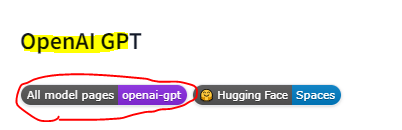

In [20]:
model_nm = 'microsoft/deberta-v3-small'

## Step 2:Get a tokenizer object for the model by using the hugging face transformer’s autoknezier.

Remember why we chose the model? It is because we want to token the input. But how do we know the right way to tokenize the input for microsoft/deberta-v3-small?

This is where HuggingFace Transformers' library [**AutoTokenizer**](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoTokenizer) class is useful.

It is a class from Transformers library that provides a convenient way to automatically load the appropriate tokenizer for a given pre-trained model.

To use it, let's first install HuggingFace transformers.

In [21]:
!pip install transformers[torch] # Google colab explicitly ask to install the transformers in this way as of 06/21/23.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
# Create HF AutoTokenizer to get the tokenizer object specific to the model we chose.
from transformers import AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [24]:
# Let's see what HF tokenizer object for our model looks like.
tokz

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-small', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [25]:
# The tokenizer has a method calls `tokenize`, which accetps a text that we want to tokenize.
tokz.tokenize("hi my name is Yunny, and this is my own GoogleColab based on my own understanding.")

['▁hi',
 '▁my',
 '▁name',
 '▁is',
 '▁Yun',
 'ny',
 ',',
 '▁and',
 '▁this',
 '▁is',
 '▁my',
 '▁own',
 '▁Google',
 'Cola',
 'b',
 '▁based',
 '▁on',
 '▁my',
 '▁own',
 '▁understanding',
 '.']

If we put the text directly as a tokz parameter, we will see three dictionaries.
`input_ids`, `token_type_ids`, and `attention_mask`.


The numerical representation of each token is in `input_ids`, and this is what we want to get.

In [29]:
tokz("hi my name is Yunny, and this is my own GoogleColab based on my own understanding.")

{'input_ids': [1, 8595, 312, 601, 269, 25263, 7087, 261, 263, 291, 269, 312, 451, 1354, 22110, 1285, 636, 277, 312, 451, 1507, 260, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

## Step 3: Prepare the inputs and the labels.
Aight so now we have a tokenizer for the model we are going to use!

### 3-(1): Prepare the inputs.
Now we want to tokenize & get `input_ids` for every single row in `input` column of the dataset.

When we apply a function to every element in the iterable, we can use python `map` function.
`map(fun, iter)`.

HF introduced [`map` utility method](https://huggingface.co/docs/datasets/process#map) that we can levearge for HF dataset.  

```
 The primary purpose of map() is to speed up processing functions. It allows you to apply a processing function to each example in a dataset, independently or in batches. This function can even create new rows and columns.
```
This class needs a single function that will be applied to each element or per batch.

So let's create a function that creates a tokz object for each row in `input` column. One tip here is that we have so many rows. So applying the function for each can take time. As such we are going to apply this per batch by using `batched=True`.

In [31]:
# Define a function that we want to apply per element or per batch of a datset.
def tok_func(x): return tokz(x["input"])

In [33]:
# Note: ds.map creates a new dataset.
# This new dataset is called `tok_ds` which has the inputs as the numerical values.
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [34]:
# You will see there are a few new columns. One of them is `input_ids`.
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

In [35]:
row = tok_ds[0]
row['input']

'TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement'

In [36]:
# row[`input_ids`] will have the list of the tokenized & numericalized values that correspond to the text in row[`input`]
row['input_ids']

[1,
 54453,
 435,
 294,
 336,
 5753,
 346,
 54453,
 445,
 294,
 47284,
 265,
 6435,
 346,
 23702,
 435,
 294,
 47284,
 2]

In [39]:
# you can see each tokenized word & corresponding numerical value by uncommenting below code.
# tokz.vocab

In [44]:
# you can see a specific word's numericalized value by
tokz.vocab['▁of']

265

### 3-(2): Prepare the labels.
Transformers always assumes that your labels has the column name **labels**, but in our dataset it's currently score. Therefore, we need to rename it:

In [46]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [47]:
# Double confirm that the `score` column is labled as `labels`.
tok_ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36473
})

## Step 4: Prepare the training set, validation set and the test set.

Okay now so far.. what we did are:
(1) Choose an NLP model that I want to use.
(2) Get a tokenizer object for the model by using the hugging face transformer’s autoknezier.
(3) Prepare the inputs and the labels.

Now the next step is.. we need to split the data for training between training and validation to avoid making our model from underfitting or overfitting into our training data.


In Transformers library, it uses DatasetDict for holding training and validation sets.

In [48]:
# Save 25% of the training data for the validation.
dds = tok_ds.train_test_split(0.25, seed=42)

In [49]:
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

### Useful references

- The importance of critical thinking in choosing the validation set: [[Rachel’s Post]](https://www.fast.ai/posts/2017-11-13-validation-sets.html)
- Validation set: a part of training data that is not used for training, but only to calculate our metric.
- Test Set: the data that is not used at all for training and validation.
    - In this specific kaggle data, it is in a different file.
    - We will use it only when we are using our model to predict the data to see how well our model is actually doing for the data that it hasn't seen.
    - We will create a test set at the last step.

  
- Why do we need the validation set? : it is to check whether our model is underfit (the function is far from representing the data) or over fit (only working well with the given data).


- Why do we need a test set?: To ensure our model is generalized enough; it is possible that we might find some factors that optimize the metrics with the validation data, but not necessarily improving our model’s performance in real life. It is one more guardrail to guarantee the performance.

- Transformers uses a `DatasetDict` for holding your training and validation sets.

## Step 5: Decide what metrics to use.
Okay now we have training set and validation set. Let's figure out a metric. So make sure to check each competition's evaluation part.

At least for kaggle, it is given. You can usually check how each competition is going to evaluate the model's performance in the [`evaluation` tab](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/overview/evaluation). In real life, it is our job to define and it can be harder.



For this particular competition, they are evaluating each model's prediction and the actual result on the Pearson correlation coefficient (r).

I don't know the details about this from mathematically perspective, but the important information for me is that it tells me how two variables are related. -1 means perfect inverse correlation and +1 is perfect positive correlation. (Jeremy covers more details and help you to build the intuitive sense by using the California Housing Dataset in the notebook. So feel free to check it out).

To calculate Pearson correlation coefficient, we need numpy library as we are going to use np.corrcoef function.

In [51]:
import numpy as np

def corr(x,y):
  return np.corrcoef(x,y)[0][1]

In [53]:
def corr_d(eval_pred):
  return {'pearson': corr(*eval_pred)} #the * in front of the variable gives the flexibility of # of parmaeters.

Please note, that np.corrcoef expects both parameters to have the same dimension.
Some models can return a result in a different format from the the dimension of the labels.

Ex:
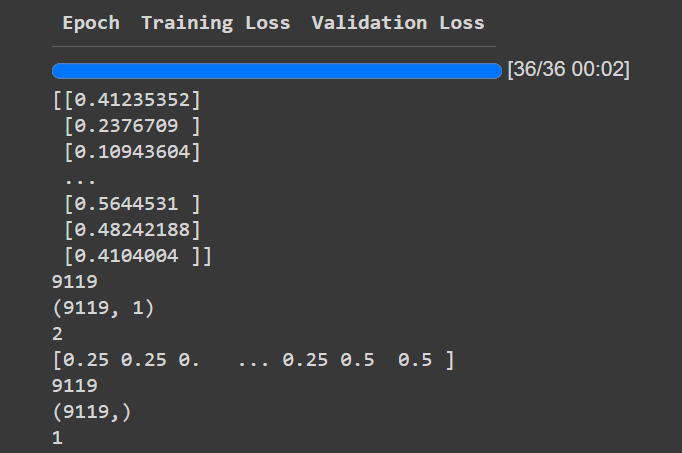


In that case, we need to update corr_d function so we can resize the predictions tensor. Check out the solution here: https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/comments#1802586

## Step 6: Train the model with our pre-processed data.

Now, we have the inputs & the labels ready, the model is ready, the training & the validation sets are ready, and the metrics is ready. So I think we are ready to ensemble altogether and train the model.

The big idea here is -
- We are going to use Transformers’ trainer object to train our model.
- For the trainer object, we need `TrainingArguments`.
- Choose relevant hyper parameters.
    - Batch size that fits our GPU (starts with 128)
    - Small number of epochs so we can run the experiments quickly. (choose 3 or 4)
    - learning rate (`lr = 8e-5`)

In [56]:
# Define hyper parameters
bs = 128
epochs = 4 # start small as the whole point is having a baseline.
lr = 8e-5

In [59]:
from transformers import TrainingArguments,Trainer

# Construct TrainingArgument with batch size, # of epochs and learning rate.
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none') #similar to data block + dataloaders

In [61]:
from transformers import AutoModelForSequenceClassification

# HF Trainer is similar to FastAI's learner (model, data, metrics).
# It combines the model, the data, training & validation sets, and the metrics.
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of the model checkpoint at microsoft/deberta-v3-small were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.classifier.weight']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from 

In [62]:
trainer.train() # This is the same as the FastAI's learner.learn method.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.026781,0.795968
2,No log,0.024363,0.822365
3,0.035900,0.023251,0.830641
4,0.035900,0.022834,0.831326


TrainOutput(global_step=856, training_loss=0.02660899574511519, metrics={'train_runtime': 217.7599, 'train_samples_per_second': 502.462, 'train_steps_per_second': 3.931, 'total_flos': 716605488222960.0, 'train_loss': 0.02660899574511519, 'epoch': 4.0})

While you are training, if you hit OutOfMemory error with CUDA, try to empty the cache or decrease the batch size.

Ex:
"OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 14.75 GiB total capacity; 13.70 GiB already allocated; 6.81 MiB free; 13.96 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation. See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF site:stackoverflow.com"

Solution:  https://medium.com/@snk.nitin/how-to-solve-cuda-out-of-memory-error-850bb247cfb2 / https://stackoverflow.com/questions/59129812/how-to-avoid-cuda-out-of-memory-in-pytorch

Some code:
```
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
```

# C. Inference
Now we completed the training our model. This means we fine-tuned the NLP model (language model) with our data (US patent) so we can use it for finding the similarity between two words/phrases.

But how do we know that this model is generalized enough so it can work well with the data that it hasn't never seen?

This is where the concept of `test set` comes in. The kaggle competition usually provides a separate file `test.csv` exactly for this purpose.

We need to do a similar process we did with the training data. We need to repet Step 2 & Step 3 in the Section A.

Then we can skip the whole section B as the purpose is to use the already fine-tuned NLP model.

## Step 1: Get the test set data & transform the data in a way that the model can use.

(1) Read the csv file and explore the data.
(2) Create a column that contains inputs that will be tokenized & numericalized and then passed to our model.


In [63]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

,id,anchor,target,context
count,36,36,36,36
unique,36,34,36,29
top,4112d61851461f60,el display,inorganic photoconductor drum,G02
freq,1,2,1,3


In [64]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

## Step 2: Inference & Apply an output layer activiation function, if needed.


In [66]:
# Our trained model is in trainer.
preds = trainer.predict(eval_ds).predictions.astype(float)

In [67]:
# Check the predictions from our model.
preds

array([[ 0.61523438],
       [ 0.65673828],
       [ 0.49121094],
       [ 0.31567383],
       [-0.01277924],
       [ 0.54785156],
       [ 0.52197266],
       [-0.04959106],
       [ 0.22583008],
       [ 1.09863281],
       [ 0.19311523],
       [ 0.24401855],
       [ 0.75292969],
       [ 0.94189453],
       [ 0.75      ],
       [ 0.48583984],
       [ 0.28295898],
       [-0.02966309],
       [ 0.65527344],
       [ 0.32299805],
       [ 0.34716797],
       [ 0.19787598],
       [ 0.17565918],
       [ 0.24194336],
       [ 0.59375   ],
       [-0.02738953],
       [-0.02792358],
       [-0.03012085],
       [-0.02604675],
       [ 0.62548828],
       [ 0.32006836],
       [-0.01899719],
       [ 0.72070312],
       [ 0.51123047],
       [ 0.4543457 ],
       [ 0.17810059]])

Hmm.. there are some negative values and there are some values that are greater than 1.  

In our problem, it does not make sense. So let's apply a function that can make the predictions more sense in our context.

This case is simple; any values should be between 0 and 1 (inclusive). If not, choose the edge value that is close to it. This means any negative value will be zero. Anything above 1, will be 1.

In [68]:
preds = np.clip(preds, 0, 1) #this is simliar to using sigmoid function.

In [69]:
preds

array([[0.61523438],
       [0.65673828],
       [0.49121094],
       [0.31567383],
       [0.        ],
       [0.54785156],
       [0.52197266],
       [0.        ],
       [0.22583008],
       [1.        ],
       [0.19311523],
       [0.24401855],
       [0.75292969],
       [0.94189453],
       [0.75      ],
       [0.48583984],
       [0.28295898],
       [0.        ],
       [0.65527344],
       [0.32299805],
       [0.34716797],
       [0.19787598],
       [0.17565918],
       [0.24194336],
       [0.59375   ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.62548828],
       [0.32006836],
       [0.        ],
       [0.72070312],
       [0.51123047],
       [0.4543457 ],
       [0.17810059]])

## Step 3: [Optional] Submit the predictions data to Kaggle or at least as a CSV file.

In [71]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

# in google colab, you will see a new file titled `submission.csv`.

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1007